# AI Fitness Coach: um Agente de IA para Criação de Treino de Musculação com LangGraph

**Disciplina:** Inteligência artificial

**Professor:** Luiz Gustavo

**Aluno:** Anderson Paes Gomes

## Objetivo

O objetivo deste trabalho é desenvolver um agente de IA capaz de gerar planos de treino de musculação personalizados e detalhados. O agente deverá ser robusto, interativo e utilizar uma arquitetura baseada em **LangGraph** para orquestrar o fluxo de trabalho. A solução deve integrar **ferramentas externas** para pesquisa na web, cálculos matemáticos e um mecanismo de Geração Aumentada por Recuperação (**RAG**).

## Funcionalidades Obrigatórias

O agente de IA deverá ser capaz de: **Coletar dados do usuário**:
- **Idade** (número inteiro).
- **Peso** (número decimal em quilogramas).
- **Periodicidade dos treinos** (número de dias na semana, de 2 a 6).
- **Objetivo principal** (por exemplo: hipertrofia, emagrecimento, força, condicionamento).

Gerar um plano de treino completo e detalhado:
- O plano deve conter 12 treinos distintos, organizados de acordo com a periodicidade e o objetivo do usuário. Por exemplo, se o usuário treina 4 dias por semana, o agente deverá gerar um plano para 3 semanas (4 treinos x 3 semanas = 12 treinos).

Cada treino deve incluir:
- **Nome do treino** (por exemplo: "Treino A - Peito e Tríceps").
- **Lista de exercícios** (com pelo menos 4 a 6 exercícios por treino).
- **Séries e repetições** recomendadas para cada exercício, adaptadas ao objetivo.

## Requisitos Técnicos e Arquitetura do Agente

A implementação do projeto deve seguir a seguinte arquitetura LangGraph, utilizando os componentes descritos: **Nó de Coleta de Dados e Validação:**

- Este nó será o ponto de entrada do agente, responsável por receber as informações do usuário e validá-las.

Nó de Consulta à Web (Ferramenta Externa):

- O agente deverá ter acesso a uma ferramenta de busca (como a API do Google Search ou uma biblioteca como requests para buscar em sites especializados).
- A busca deve ser usada para **encontrar as melhores práticas** de treino para o objetivo e periodicidade fornecidos. Por exemplo, pesquisar por "treino de hipertrofia 4 dias por semana" ou "exercícios para emagrecimento".

Nó de Cálculo Matemático (Ferramenta Externa):

- O agente deve possuir uma ferramenta capaz de realizar **cálculos**.
- Essa ferramenta pode ser uma função Python que, com base na idade, peso e objetivo, pode **estimar o gasto calórico** aproximado por treino ou calcular o **IMC** para contextualizar as recomendações.
- A ferramenta pode ser usada para **otimizar a divisão dos treinos** e a distribuição dos exercícios, garantindo que o plano seja balanceado.

Nó RAG (Geração Aumentada por Recuperação):

- O agente deve ter uma **base de conhecimento interna** (vetorizada) contendo informações detalhadas sobre exercícios (nome, músculos trabalhados, dicas de execução), teoria do treinamento (princípios de hipertrofia, força, etc.) e exemplos de rotinas de treino.
- Essa base de dados deve ser consultada para **garantir a precisão e a qualidade** das recomendações, enriquecendo o plano de treino com descrições detalhadas dos exercícios.

Nó de Geração de Conteúdo:

- Este nó orquestra todas as informações coletadas (da web, dos cálculos e do RAG) para **gerar o plano de treino final**. A saída deve ser um texto formatado de maneira clara e organizada, ou até mesmo um arquivo (ex: .txt ou .pdf).

## Importação das bibliotecas / Carregamento do modelo

In [ ]:
import json
import math
import os
import re
from pathlib import Path
from typing import Any, Dict, List, Optional

try:
    import ipywidgets as widgets
except ImportError:
    widgets = None

try:
    from IPython.display import Markdown, display
except ImportError:
    def Markdown(x):
        return x
    def display(x):
        print(x)

from IPython.display import Image
from dotenv import find_dotenv, load_dotenv
from duckduckgo_search import DDGS
from pydantic import BaseModel, Field, PositiveFloat, PositiveInt, ValidationError
from typing_extensions import TypedDict

from langchain_groq import ChatGroq
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.tools import tool
from langchain.tools.retriever import create_retriever_tool
from langchain.output_parsers.json import parse_json_markdown
from langchain_community.document_loaders import PyPDFLoader
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores import FAISS

from langgraph.graph import StateGraph, START, END

In [2]:
load_dotenv(find_dotenv(usecwd=True))

groq_key = os.environ.get("GROQ_API_KEY")
if not groq_key:
    raise ValueError("GROQ_API_KEY nao encontrado. Defina no arquivo .env antes de continuar.")


def load_llm(model_id: str, temperature: float) -> ChatGroq:
    return ChatGroq(
        model=model_id,
        temperature=temperature,
        max_tokens=None,
        timeout=None,
        max_retries=2,
    )


MODEL_ID = "llama-3.1-8b-instant"  # modelo suportado pela API da Groq
TEMPERATURE = 0.6

llm = load_llm(MODEL_ID, TEMPERATURE)
print(f"LLM pronto: {MODEL_ID}")

LLM pronto: llama-3.1-8b-instant


## Estruturas de dados e validacao do perfil

In [3]:
SUPPORTED_GOALS: Dict[str, str] = {
    "hipertrofia": "foco em aumento de massa muscular",
    "emagrecimento": "foco em reducao de gordura corporal",
    "forca": "foco em ganhos de carga maxima e potencia",
    "condicionamento": "foco em resistencia metabolica e cardiovascular",
}

EXPERIENCE_LEVELS = ["iniciante", "intermediario", "avancado"]


class PerfilUsuario(BaseModel):
    age: PositiveInt = Field(ge=15, le=80, description="Idade em anos")
    weight_kg: PositiveFloat = Field(gt=35, lt=250, description="Peso corporal em kg")
    height_cm: Optional[PositiveFloat] = Field(default=None, ge=140, le=220, description="Altura em cm")
    training_frequency: PositiveInt = Field(ge=2, le=6, description="Numero de treinos por semana")
    primary_goal: str = Field(description="Objetivo principal. Use uma das chaves de SUPPORTED_GOALS")
    experience_level: str = Field(default="iniciante", description="iniciante, intermediario ou avancado")
    restrictions: Optional[str] = Field(default=None, description="Lesoes ou limitacoes")
    additional_notes: Optional[str] = Field(default=None, description="Observacoes gerais")


def normalizar_objetivo(goal: str) -> str:
    goal_key = goal.lower().strip()
    if goal_key not in SUPPORTED_GOALS:
        raise ValueError(
            f"Objetivo '{goal}' invalido. Escolha entre: {', '.join(SUPPORTED_GOALS.keys())}."
        )
    return goal_key


def normalizar_experiencia(level: str) -> str:
    key = level.lower().strip()
    if key not in EXPERIENCE_LEVELS:
        raise ValueError(
            f"Nivel de experiencia '{level}' invalido. Use um dos valores: {', '.join(EXPERIENCE_LEVELS)}."
        )
    return key

## Construindo a base de conhecimento (RAG) a partir de `treino/enciclopedia.pdf`

In [4]:
ARTIFACTS_DIR = Path("artefacts")
ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)

PDF_PATH = Path("treino/enciclopedia.pdf")
if not PDF_PATH.exists():
    raise FileNotFoundError("O arquivo treino/enciclopedia.pdf nao foi encontrado.")

VECTORSTORE_DIR = ARTIFACTS_DIR / "fitness_faiss_index"
EMBEDDING_MODEL = "sentence-transformers/all-MiniLM-L6-v2"

embeddings = HuggingFaceEmbeddings(model_name=EMBEDDING_MODEL)


def load_vectorstore(force_rebuild: bool = False) -> FAISS:
    index_file = VECTORSTORE_DIR / "index.faiss"
    if not force_rebuild and index_file.exists():
        print("Carregando indice vetorial local...")
        return FAISS.load_local(
            str(VECTORSTORE_DIR), embeddings, allow_dangerous_deserialization=True
        )

    print("Construindo indice vetorial a partir do PDF. Este passo pode levar alguns minutos...")
    loader = PyPDFLoader(str(PDF_PATH))
    docs = loader.load()

    splitter = RecursiveCharacterTextSplitter(
        chunk_size=900,
        chunk_overlap=150,
        separators=["\\n\\n", "\\n", ".", " "],
    )
    chunks = splitter.split_documents(docs)
    print(f"Total de blocos gerados: {len(chunks)}")

    store = FAISS.from_documents(chunks, embeddings)
    store.save_local(str(VECTORSTORE_DIR))
    return store


vectorstore = load_vectorstore(force_rebuild=False)
retriever = vectorstore.as_retriever(search_kwargs={"k": 8})
print("Retriever preparado.")

C:\Users\Administrador\AppData\Local\Temp\ipykernel_16772\2588588930.py:11: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceEmbeddings(model_name=EMBEDDING_MODEL)


Carregando indice vetorial local...
Retriever preparado.


## Ferramentas externas: pesquisa, calculo e RAG

In [5]:
@tool
def ferramenta_pesquisa_web(query: str, max_results: int = 4) -> List[Dict[str, str]]:
    '''Busca textos na web usando DuckDuckGo para complementar recomendacoes.'''
    results: List[Dict[str, str]] = []
    if not query:
        return results

    try:
        with DDGS() as ddgs:
            for item in ddgs.text(
                query,
                region="br-pt",
                safesearch="moderate",
                max_results=max_results,
            ):
                results.append(
                    {
                        "title": item.get("title", ""),
                        "snippet": item.get("body", ""),
                        "url": item.get("href", ""),
                    }
                )
    except Exception as exc:  # noqa: BLE001
        results.append({
            "title": "erro na pesquisa",
            "snippet": f"Falha ao consultar DuckDuckGo: {exc}",
            "url": ""
        })

    return results


@tool
def ferramenta_matematica_treino(
    age: int,
    weight_kg: float,
    training_frequency: int,
    primary_goal: str,
    height_cm: Optional[float] = None,
    experience_level: str = "iniciante",
) -> Dict[str, Any]:
    '''Calcula IMC, gasto calorico estimado e orientacoes de volume por sessao.'''
    goal_key = primary_goal.lower().strip()
    goal_presets = {
        "hipertrofia": {
            "met": 6.0,
            "duration_hours": 1.2,
            "rep_range": "6-12",
            "intensity": "70-80% 1RM",
        },
        "emagrecimento": {
            "met": 5.5,
            "duration_hours": 1.15,
            "rep_range": "12-15",
            "intensity": "Circuitos com pausa curta",
        },
        "forca": {
            "met": 6.8,
            "duration_hours": 1.25,
            "rep_range": "3-6",
            "intensity": "80-90% 1RM",
        },
        "condicionamento": {
            "met": 7.2,
            "duration_hours": 1.05,
            "rep_range": "10-15",
            "intensity": "Intervalos moderados",
        },
    }

    if goal_key not in goal_presets:
        raise ValueError(
            f"Objetivo {primary_goal} nao suportado em ferramenta_matematica_treino."
        )

    preset = goal_presets[goal_key]

    bmi = None
    if height_cm:
        height_m = height_cm / 100
        bmi = round(weight_kg / (height_m ** 2), 2)

    session_calories = round(weight_kg * preset["met"] * preset["duration_hours"], 1)
    weekly_calories = round(session_calories * training_frequency, 1)

    volume_table = {
        "iniciante": "14-18 series por grupamento",
        "intermediario": "18-22 series por grupamento",
        "avancado": "22-26 series por grupamento",
    }
    volume = volume_table.get(experience_level.lower(), "18-22 series por grupamento")

    return {
        "goal": goal_key,
        "estimated_session_calories": session_calories,
        "estimated_weekly_calories": weekly_calories,
        "bmi": bmi,
        "recommended_rep_range": preset["rep_range"],
        "recommended_intensity": preset["intensity"],
        "volume_per_session": volume,
        "sessions_per_week": training_frequency,
        "experience_level": experience_level.lower(),
    }


ferramenta_retriever = create_retriever_tool(
    retriever,
    "fitness_rag",
    "Recupera trechos tecnicos da enciclopedia de musculacao para embasar o plano.",
)

## Suporte a formato de saida e funcoes utilitarias

In [6]:
def extract_json_payload(raw_text: str) -> Optional[Dict[str, Any]]:
    if not raw_text:
        return None

    def normalize_keys(obj):
        if isinstance(obj, dict):
            normalized = {}
            for key, value in obj.items():
                if isinstance(key, str):
                    cleaned = key.strip().strip('"')
                else:
                    cleaned = key
                normalized[cleaned] = normalize_keys(value)
            return normalized
        if isinstance(obj, list):
            return [normalize_keys(item) for item in obj]
        return obj

    def locate_plan_dict(obj):
        if isinstance(obj, dict):
            normalized_keys = {str(k).strip().lower(): k for k in obj.keys()}
            if "overview" in normalized_keys and "training_weeks" in normalized_keys:
                return obj
            for value in obj.values():
                found = locate_plan_dict(value)
                if found is not None:
                    return found
        elif isinstance(obj, list):
            for item in obj:
                found = locate_plan_dict(item)
                if found is not None:
                    return found
        return None

    candidates: List[Any] = []

    try:
        parsed = parse_json_markdown(raw_text)
    except Exception:  # noqa: BLE001
        parsed = None

    if parsed is not None:
        candidates.append(parsed)

    pattern = re.compile(r"```json\s*(.*?)```", re.DOTALL)
    for match in pattern.finditer(raw_text):
        candidates.append(match.group(1))

    raw_strip = raw_text.strip()
    if raw_strip:
        candidates.append(raw_strip)

    decoder = json.JSONDecoder()
    for idx, char in enumerate(raw_text):
        if char in '{[':
            try:
                loaded, _ = decoder.raw_decode(raw_text[idx:].strip())
            except json.JSONDecodeError:
                continue
            candidates.append(loaded)
            break

    for candidate in candidates:
        normalized_candidate = None

        if isinstance(candidate, dict):
            normalized_candidate = normalize_keys(candidate)
        elif isinstance(candidate, list):
            normalized_candidate = normalize_keys(candidate)
        elif isinstance(candidate, str):
            snippet = candidate.strip().strip('```').strip()
            if snippet.startswith('{') or snippet.startswith('['):
                try:
                    loaded = json.loads(snippet)
                except json.JSONDecodeError:
                    continue
                normalized_candidate = normalize_keys(loaded)

        if normalized_candidate is None:
            continue

        if isinstance(normalized_candidate, dict):
            plan_dict = locate_plan_dict(normalized_candidate)
            if plan_dict is not None:
                return plan_dict
        elif isinstance(normalized_candidate, list):
            for item in normalized_candidate:
                if isinstance(item, dict):
                    plan_dict = locate_plan_dict(item)
                    if plan_dict is not None:
                        return plan_dict

    return None




## Definicao dos nos do LangGraph

In [7]:
class EstadoCoach(TypedDict, total=False):
    raw_profile: Dict[str, Any]
    user_profile: Dict[str, Any]
    web_research: List[Dict[str, Any]]
    analises: Dict[str, Any]
    rag_context: List[Dict[str, Any]]
    plan_payload: Dict[str, Any]
    plan_markdown: str
    raw_llm_output: str


def coletar_perfil_usuario(state: EstadoCoach) -> EstadoCoach:
    carga = dict(state.get("raw_profile", {}))
    if not carga:
        raise ValueError("Nenhum dado foi informado para o perfil do usuario.")

    try:
        carga["primary_goal"] = normalizar_objetivo(carga.get("primary_goal", ""))
        carga["experience_level"] = normalizar_experiencia(
            carga.get("experience_level", "iniciante")
        )
        perfil = PerfilUsuario(**carga)
    except (ValidationError, ValueError) as exc:
        raise ValueError(f"Falha na validacao do perfil: {exc}") from exc

    profile_data = perfil.model_dump()
    profile_data["primary_goal"] = normalizar_objetivo(profile_data["primary_goal"])
    profile_data["experience_level"] = normalizar_experiencia(profile_data["experience_level"])

    return {"user_profile": profile_data}


def no_pesquisa_web(state: EstadoCoach) -> EstadoCoach:
    perfil = state.get("user_profile")
    if not perfil:
        raise ValueError("Perfil nao encontrado para pesquisa.")

    goal = perfil["primary_goal"]
    freq = perfil["training_frequency"]

    queries = [
        f"treino de musculacao {goal} {freq} dias por semana",
        f"melhores exercicios para {goal} academia",
        f"divisao de treino {freq} dias hipertrofia" if goal == "hipertrofia" else f"estrategias de treino para {goal}",
    ]

    research_payload: List[Dict[str, Any]] = []
    for query in queries:
        results = ferramenta_pesquisa_web.invoke({"query": query, "max_results": 4})
        research_payload.append({"query": query, "results": results})

    return {"web_research": research_payload}


def no_calculos(state: EstadoCoach) -> EstadoCoach:
    perfil = state.get("user_profile")
    if not perfil:
        raise ValueError("Perfil nao encontrado para calculos.")

    args = {
        "age": perfil["age"],
        "weight_kg": perfil["weight_kg"],
        "training_frequency": perfil["training_frequency"],
        "primary_goal": perfil["primary_goal"],
        "height_cm": perfil.get("height_cm"),
        "experience_level": perfil.get("experience_level", "iniciante"),
    }
    analises = ferramenta_matematica_treino.invoke(args)
    return {"analises": analises}


def no_rag(state: EstadoCoach) -> EstadoCoach:
    perfil = state.get("user_profile")
    if not perfil:
        raise ValueError("Perfil nao encontrado para consulta ao RAG.")

    goal = perfil["primary_goal"]
    freq = perfil["training_frequency"]

    queries = [
        f"principios de treino para {goal}",
        f"exercicios compostos para {goal}",
        f"como distribuir musculos em {freq} dias de treino",
    ]

    rag_payload: List[Dict[str, Any]] = []
    for query in queries:
        docs = retriever.invoke(query)
        for doc in docs:
            rag_payload.append(
                {
                    "query": query,
                    "content": doc.page_content[:600],
                    "source": str(doc.metadata.get("source", "")),
                    "page": doc.metadata.get("page", doc.metadata.get("page_number")),
                }
            )

    unique: List[Dict[str, Any]] = []
    seen = set()
    for item in rag_payload:
        key = item["content"][:120]
        if key in seen:
            continue
        seen.add(key)
        unique.append(item)
        if len(unique) >= 8:
            break

    return {"rag_context": unique}

## Prompt e no final de geracao do plano

In [ ]:
def renderizar_plano_markdown(plan_payload: dict) -> str:
    """Converte o dicionário de plano de treino em um texto Markdown legível."""
    lines = []
    overview = plan_payload.get("overview", {})
    if overview:
        lines.append("## Visão geral")
        primary_goal = overview.get("primary_goal")
        if primary_goal:
            lines.append(f"- **Objetivo principal:** {primary_goal}")
        focus_points = overview.get("focus_points")
        if focus_points:
            if isinstance(focus_points, list):
                focus_str = ", ".join(str(fp) for fp in focus_points)
            else:
                focus_str = str(focus_points)
            lines.append(f"- **Pontos de foco:** {focus_str}")
        macro_weeks = overview.get("macrocycle_length_weeks")
        if macro_weeks:
            lines.append(f"- **Duração do macrociclo:** {macro_weeks} semanas")
        lines.append("")

    # Guidelines
    guidelines = plan_payload.get("guidelines")
    if guidelines:
        lines.append("## Diretrizes")
        for item in guidelines:
            lines.append(f"- {item}")
        lines.append("")

    # Training weeks
    training_weeks = plan_payload.get("training_weeks")
    if training_weeks:
        lines.append("## Semanas de treino")
        for week in training_weeks:
            week_num = week.get("week")
            focus = week.get("focus")
            if week_num is not None:
                header = f"### Semana {week_num}"
                if focus:
                    header += f": {focus}"
                lines.append(header)
            sessions = week.get("sessions", [])
            for session_idx, session in enumerate(sessions, 1):
                day = session.get("day")
                name = session.get("name") or f"Sessão {session_idx}"
                focus_sess = session.get("focus")
                session_header = f"#### {name}" if name else "#### Sessão"
                if focus_sess:
                    session_header += f" – {focus_sess}"
                lines.append(session_header)
                resumo = session.get("resumo")
                if resumo:
                    lines.append(f"{resumo}")

                # Exercises
                exercises = session.get("exercises", [])
                if exercises:
                    lines.append("##### Exercícios")
                    for ex in exercises:
                        exercise_name = ex.get("exercise")
                        sets = ex.get("sets")
                        reps = ex.get("reps")
                        rest = ex.get("rest")
                        notes = ex.get("notes")
                        parts = []
                        if sets is not None:
                            parts.append(f"{sets}x")
                        if reps is not None:
                            parts.append(str(reps))
                        if rest:
                            parts.append(f"descanso {rest}")
                        rep_str = " ".join(parts)
                        line = f"- {exercise_name} {rep_str}" if exercise_name else "-"
                        if notes:
                            line += f" – {notes}"
                        lines.append(line)

                # Conditioning, mobility, progression
                conditioning = session.get("conditioning")
                if conditioning:
                    lines.append(f"- **Condicionamento:** {conditioning}")
                mobility = session.get("mobility")
                if mobility:
                    lines.append(f"- **Mobilidade:** {mobility}")
                progression = session.get("progression")
                if progression:
                    lines.append(f"- **Progressão:** {progression}")
                lines.append("")
        lines.append("")

    # Recovery
    recovery = plan_payload.get("recovery")
    if recovery:
        lines.append("## Recuperação")
        for item in recovery:
            lines.append(f"- {item}")
        lines.append("")

    # Nutrition tips
    nutrition = plan_payload.get("nutrition_tips")
    if nutrition:
        lines.append("## Dicas de nutrição")
        for tip in nutrition:
            lines.append(f"- {tip}")
        lines.append("")
        
    # Progression strategy
    progression_strategy = plan_payload.get("progression_strategy")
    if progression_strategy:
        lines.append("## Estratégia de progressão")
        lines.append(progression_strategy)
        lines.append("")
    return "\n".join(lines)


In [ ]:
PLAN_SYSTEM_PROMPT = '''

Voce e um treinador de musculacao experiente. Crie planos realistas, seguros e detalhados.
Siga as regras:
- Gere exatamente 12 sessoes de treino no total, distribuindo-as ao longo das semanas conforme a frequencia semanal informada.
- Cada sessao deve conter entre 4 e 6 exercicios com series, repeticoes e descanso adequados.
- Ajuste foco muscular, tempo sob tensao e intensidades conforme o objetivo principal e o nivel de experiencia.
- Inclua estrategias de aquecimento, mobilidade ou condicionamento quando relevante.
- Garanta equilibrio entre grupamentos musculares ao longo da semana.
- Sua resposta deve ser estritamente o JSON solicitado, sem texto adicional ou comentarios.
- Responda exclusivamente em JSON valido com a seguinte estrutura:
{
  "overview": {
    "primary_goal": str,
    "focus_points": [str],
    "macrocycle_length_weeks": int
  },
  "guidelines": [str],
  "training_weeks": [
    {
      "week": int,
      "focus": str,
      "sessions": [
        {
          "day": int,
          "name": str,
          "focus": str,
          "resumo": str,
          "exercises": [
            {
              "exercise": str,
              "sets": int,
              "reps": str,
              "rest": str,
              "notes": str
            }
          ],
          "conditioning": str,
          "mobility": str,
          "progression": str
        }
      ]
    }
  ],
  "recovery": [str],
  "nutrition_tips": [str],
  "progression_strategy": str
}
'''

PLAN_SYSTEM_PROMPT = PLAN_SYSTEM_PROMPT.replace('{', '{{').replace('}', '}}')

PLAN_HUMAN_PROMPT = '''
Perfil do usuario:
{perfil}

Insights de pesquisa:
{web_research}

Metricas calculadas:
{analises}

Contexto tecnico da base interna:
{rag_context}

Elabore um plano completo seguindo as regras acima. Inclua variacoes adequadas e destaque sugestoes de progressao.
'''

plan_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", PLAN_SYSTEM_PROMPT.strip()),
        ("human", PLAN_HUMAN_PROMPT.strip()),
    ]
)


def no_plano(state: EstadoCoach) -> EstadoCoach:
    perfil = state.get("user_profile")
    if not perfil:
        raise ValueError("Perfil nao encontrado para gerar o plano final.")

    web_research = state.get("web_research", [])
    analises = state.get("analises", {})
    rag_context = state.get("rag_context", [])

    messages = plan_prompt.format_messages(
        perfil=json.dumps(perfil, ensure_ascii=False, indent=2),
        web_research=json.dumps(web_research, ensure_ascii=False, indent=2),
        analises=json.dumps(analises, ensure_ascii=False, indent=2),
        rag_context=json.dumps(rag_context, ensure_ascii=False, indent=2),
    )

    response = llm.invoke(messages)
    plan_payload = extract_json_payload(response.content)
    if plan_payload is None:
        raise ValueError("Falha ao interpretar a resposta do modelo. Verifique o log bruto.")


    return {
        "plan_payload": plan_payload,
        "plan_markdown": plan_payload,
        "raw_llm_output": response.content,
    }

## Construindo e visualizando o grafo do agente

In [10]:
graph_builder = StateGraph(EstadoCoach)

graph_builder.add_node("coleta", coletar_perfil_usuario)
graph_builder.add_node("pesquisa_web", no_pesquisa_web)
graph_builder.add_node("calculos", no_calculos)
graph_builder.add_node("rag", no_rag)
graph_builder.add_node("plano", no_plano)

graph_builder.add_edge(START, "coleta")
graph_builder.add_edge("coleta", "pesquisa_web")
graph_builder.add_edge("pesquisa_web", "calculos")
graph_builder.add_edge("calculos", "rag")
graph_builder.add_edge("rag", "plano")
graph_builder.add_edge("plano", END)

coach_graph = graph_builder.compile()
print("Grafo compilado com sucesso.")

Grafo compilado com sucesso.


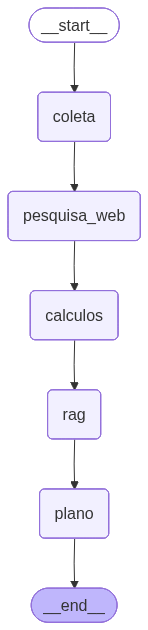

In [ ]:
display(Image(coach_graph.get_graph().draw_mermaid_png()))

## Funcoes auxiliares para execucao programatica

In [ ]:
def executar_fluxo(perfil: Dict[str, Any], debug: bool = False) -> EstadoCoach:
    carga = {"raw_profile": perfil}
    
    if debug:
        for event in coach_graph.stream(carga):
            print(event)
    resultado = coach_graph.invoke(carga, output_keys=["plan_payload", "raw_llm_output", "user_profile", "analises", "web_research"])

    if isinstance(resultado, dict) and resultado.get("plan_payload") is not None:
        try:
            resultado["plan_markdown"] = renderizar_plano_markdown(resultado["plan_payload"])
        except Exception as _e:
            resultado["plan_markdown"] = json.dumps(resultado.get("plan_payload"), ensure_ascii=False, indent=2)
    return resultado


def formatar_analises(analises: Dict[str, Any]) -> str:
    if not analises:
        return ""
    parts = [
        f"- Calorias estimadas por sessao: {analises.get('estimated_session_calories')} kcal",
        f"- Calorias semanais aproximadas: {analises.get('estimated_weekly_calories')} kcal",
        f"- Faixa de repeticoes sugerida: {analises.get('recommended_rep_range')}",
        f"- Intensidade sugerida: {analises.get('recommended_intensity')}",
        f"- Volume por sessao: {analises.get('volume_per_session')}",
    ]
    if analises.get('bmi'):
        parts.append(f"- IMC aproximado: {analises['bmi']}")
    return "\n".join(parts)




In [13]:
def resumir_pesquisa_web(pesquisa: List[Dict[str, Any]]) -> List[str]:
    """
    Resume os resultados de pesquisa retornados pelo nó de pesquisa web.
    Para cada consulta, pega o primeiro resultado e extrai um titulo ou URL
    como referencia. Se nao houver resultados, retorna apenas a consulta.
    """
    summaries: List[str] = []
    for item in pesquisa or []:
        query = item.get("query", "")
        results = item.get("results", [])
        resumo: str | None = None
        if isinstance(results, list) and results:
            first = results[0]
            if isinstance(first, dict):
                title = first.get("title") or first.get("href") or first.get("content")
                resumo = title if title else str(first)
            else:
                resumo = str(first)
        if resumo:
            summaries.append(f"{query}: {resumo}")
        else:
            summaries.append(query)
    return summaries


## Interface interativa com ipywidgets

In [ ]:
def construir_app():
    if widgets is None:
        raise ImportError('ipywidgets nao esta instalado; a interface interativa nao esta disponivel neste ambiente.')
    opcoes_objetivo = [
        ("Hipertrofia", "hipertrofia"),
        ("Emagrecimento", "emagrecimento"),
        ("Forca", "forca"),
        ("Condicionamento", "condicionamento"),
    ]

    opcoes_frequencia = [2, 3, 4, 5, 6]

    entrada_idade = widgets.BoundedIntText(value=25, min=15, max=80, description="Idade")
    entrada_peso = widgets.BoundedFloatText(value=75.0, min=40.0, max=200.0, step=0.5, description="Peso (kg)")
    entrada_altura = widgets.Text(value="", placeholder="Opcional", description="Altura (cm)")
    entrada_frequencia = widgets.Dropdown(options=opcoes_frequencia, value=4, description="Frequencia")
    entrada_objetivo = widgets.Dropdown(options=opcoes_objetivo, value="hipertrofia", description="Objetivo")
    entrada_nivel = widgets.Dropdown(options=EXPERIENCE_LEVELS, value="iniciante", description="Nivel")
    entrada_restricoes = widgets.Textarea(value="", placeholder="Ex: dor no ombro", description="Restricoes")
    entrada_notas = widgets.Textarea(value="", placeholder="Observacoes adicionais", description="Notas")

    botao_gerar = widgets.Button(description="Gerar plano", button_style="success")
    saida = widgets.Output(layout=widgets.Layout(border="1px solid #ccc", padding="10px"))

    def on_generate(_):
        carga = {
            "age": entrada_idade.value,
            "weight_kg": float(entrada_peso.value),
            "training_frequency": int(entrada_frequencia.value),
            "primary_goal": entrada_objetivo.value,
            "experience_level": entrada_nivel.value,
            "restrictions": entrada_restricoes.value.strip() or None,
            "additional_notes": entrada_notas.value.strip() or None,
        }

        altura_raw = entrada_altura.value.strip()
        if altura_raw:
            try:
                carga["height_cm"] = float(altura_raw)
            except ValueError:
                with saida:
                    saida.clear_output()
                    display(Markdown("Altura invalida. Informe em centimetros (por exemplo, 175)."))
                return

        saida.clear_output()
        with saida:
            try:
                resultado = executar_fluxo(carga)
            except Exception as exc:  # noqa: BLE001
                display(Markdown(f"**Erro:** {exc}"))
                return

            perfil = resultado.get("user_profile", {})
            analises = resultado.get("analises", {})
            pesquisa = resultado.get("web_research", [])

            display(Markdown("### Perfil validado"))
            display(Markdown(f"- Idade: {perfil.get('age')} anos"))
            display(Markdown(f"- Peso: {perfil.get('weight_kg')} kg"))
            if perfil.get("height_cm"):
                display(Markdown(f"- Altura: {perfil.get('height_cm')} cm"))
            display(Markdown(f"- Frequencia semanal: {perfil.get('training_frequency')} dias"))
            display(Markdown(f"- Objetivo: {perfil.get('primary_goal')}"))
            display(Markdown(f"- Nivel: {perfil.get('experience_level')}"))

            display(Markdown("### Insights analiticos"))
            display(Markdown(formatar_analises(analises)))

            try:
                resumo = resumir_pesquisa_web(pesquisa)
            except NameError:
                # Fallback summarization logic when resumir_pesquisa_web is not defined
                resumo = []
                for item in pesquisa or []:
                    query = item.get("query", "")
                    results = item.get("results", [])
                    summary_text = None
                    if isinstance(results, list) and results:
                        first = results[0]
                        if isinstance(first, dict):
                            title = first.get("title") or first.get("href") or first.get("content")
                            summary_text = title if title else str(first)
                        else:
                            summary_text = str(first)
                    resumo.append(f"{query}: {summary_text}" if summary_text else query)
            if resumo:
                display(Markdown("### Referencias encontradas na web"))
                for item in resumo:
                    display(Markdown(f"- {item}"))

            display(Markdown("### Plano final"))
            display(Markdown(resultado.get("plan_markdown", "Plano nao gerado.")))

    botao_gerar.on_click(on_generate)

    itens_formulario = widgets.VBox(
        [
            entrada_idade,
            entrada_peso,
            entrada_altura,
            entrada_frequencia,
            entrada_objetivo,
            entrada_nivel,
            entrada_restricoes,
            entrada_notas,
            botao_gerar,
        ],
        layout=widgets.Layout(width="45%"),
    )

    aplicacao = widgets.HBox(
        [
            itens_formulario,
            widgets.VBox([widgets.Label("Resultado"), saida], layout=widgets.Layout(width="55%")),
        ]
    )

    display(aplicacao)


def iniciar_app():
    """Inicia a interface interativa se ipywidgets estiver disponivel."""
    if widgets is None:
        print("ipywidgets nao esta instalado; a interface interativa nao esta disponivel neste ambiente.\nUse a funcao executar_fluxo() para gerar um plano com um dicionario de perfil.")
        return
    construir_app()

iniciar_app()

## Execucao programatica opcional (exemplo rapido)

In [ ]:
example_profile = {
    "age": 32,
    "weight_kg": 82.0,
    "height_cm": 178.0,
    "training_frequency": 4,
    "primary_goal": "hipertrofia",
    "experience_level": "intermediario",
}

# A linha abaixo para gerar um plano diretamente sem usar a interface.
resultado = executar_fluxo(example_profile, debug=False)
display(Markdown(resultado["plan_markdown"]))

C:\Users\Administrador\AppData\Local\Temp\ipykernel_16772\2291423852.py:9: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  with DDGS() as ddgs:
C:\Users\Administrador\AppData\Local\Temp\ipykernel_16772\2291423852.py:9: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  with DDGS() as ddgs:
C:\Users\Administrador\AppData\Local\Temp\ipykernel_16772\2291423852.py:9: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  with DDGS() as ddgs:


## Visão geral
- **Objetivo principal:** hipertrofia
- **Pontos de foco:** equilíbrio entre grupamentos musculares, sobrecarga progressiva
- **Duração do macrociclo:** 4 semanas

## Diretrizes
- Ajuste o treino de acordo com as necessidades individuais do cliente.
- Aumente gradualmente a intensidade e o volume do treino ao longo do macrociclo.
- Foque em técnicas de levantamento corretas e seguras.

## Semanas de treino
### Semana 1: principais exercícios de força
#### Treino A – peito, tríceps e abdominais
Treino com foco em peito, tríceps e abdominais.
##### Exercícios
- Supino com barra 3x 6-8 descanso 60-90 segundos – Aumente a carga gradualmente.
- Tríceps com barra 3x 8-12 descanso 60-90 segundos – Ajuste a amplitude do movimento para melhorar a eficácia do exercício.
- Levantamento de peso livre 3x 12-15 descanso 60-90 segundos – Aumente a carga gradualmente.
- **Condicionamento:** 15-20 minutos de cardio suave.
- **Mobilidade:** 5-10 minutos de mobilidade para os músculos do peito e tríceps.
- **Progressão:** Aumente a carga e a amplitude do movimento gradualmente.

#### Treino B – ombros e bíceps
Treino com foco em ombros e bíceps.
##### Exercícios
- Pressão com halteres 3x 8-12 descanso 60-90 segundos – Ajuste a amplitude do movimento para melhorar a eficácia do exercício.
- Curl com halteres 3x 12-15 descanso 60-90 segundos – Aumente a carga gradualmente.
- Levantamento de peso livre 3x 15-20 descanso 60-90 segundos – Ajuste a amplitude do movimento para melhorar a eficácia do exercício.
- **Condicionamento:** 15-20 minutos de cardio suave.
- **Mobilidade:** 5-10 minutos de mobilidade para os músculos dos ombros e bíceps.
- **Progressão:** Aumente a carga e a amplitude do movimento gradualmente.

#### Treino C – costas e panturrilha
Treino com foco em costas e panturrilha.
##### Exercícios
- Remada com barra 3x 8-12 descanso 60-90 segundos – Ajuste a amplitude do movimento para melhorar a eficácia do exercício.
- Levantamento de peso livre 3x 12-15 descanso 60-90 segundos – Aumente a carga gradualmente.
- Levantamento de peso livre 3x 15-20 descanso 60-90 segundos – Ajuste a amplitude do movimento para melhorar a eficácia do exercício.
- **Condicionamento:** 15-20 minutos de cardio suave.
- **Mobilidade:** 5-10 minutos de mobilidade para os músculos das costas e panturrilha.
- **Progressão:** Aumente a carga e a amplitude do movimento gradualmente.

#### Treino D – pernas e tríceps
Treino com foco em pernas e tríceps.
##### Exercícios
- Levantamento de peso livre 3x 8-12 descanso 60-90 segundos – Ajuste a amplitude do movimento para melhorar a eficácia do exercício.
- Tríceps com barra 3x 12-15 descanso 60-90 segundos – Aumente a carga gradualmente.
- Levantamento de peso livre 3x 15-20 descanso 60-90 segundos – Ajuste a amplitude do movimento para melhorar a eficácia do exercício.
- **Condicionamento:** 15-20 minutos de cardio suave.
- **Mobilidade:** 5-10 minutos de mobilidade para os músculos das pernas e tríceps.
- **Progressão:** Aumente a carga e a amplitude do movimento gradualmente.

### Semana 2: exercícios auxiliares
#### Treino A – peito, tríceps e abdominais
Treino com foco em peito, tríceps e abdominais.
##### Exercícios
- Supino com barra 3x 6-8 descanso 60-90 segundos – Aumente a carga gradualmente.
- Tríceps com barra 3x 8-12 descanso 60-90 segundos – Ajuste a amplitude do movimento para melhorar a eficácia do exercício.
- Levantamento de peso livre 3x 12-15 descanso 60-90 segundos – Aumente a carga gradualmente.
- **Condicionamento:** 15-20 minutos de cardio suave.
- **Mobilidade:** 5-10 minutos de mobilidade para os músculos do peito e tríceps.
- **Progressão:** Aumente a carga e a amplitude do movimento gradualmente.

#### Treino B – ombros e bíceps
Treino com foco em ombros e bíceps.
##### Exercícios
- Pressão com halteres 3x 8-12 descanso 60-90 segundos – Ajuste a amplitude do movimento para melhorar a eficácia do exercício.
- Curl com halteres 3x 12-15 descanso 60-90 segundos – Aumente a carga gradualmente.
- Levantamento de peso livre 3x 15-20 descanso 60-90 segundos – Ajuste a amplitude do movimento para melhorar a eficácia do exercício.
- **Condicionamento:** 15-20 minutos de cardio suave.
- **Mobilidade:** 5-10 minutos de mobilidade para os músculos dos ombros e bíceps.
- **Progressão:** Aumente a carga e a amplitude do movimento gradualmente.

#### Treino C – costas e panturrilha
Treino com foco em costas e panturrilha.
##### Exercícios
- Remada com barra 3x 8-12 descanso 60-90 segundos – Ajuste a amplitude do movimento para melhorar a eficácia do exercício.
- Levantamento de peso livre 3x 12-15 descanso 60-90 segundos – Aumente a carga gradualmente.
- Levantamento de peso livre 3x 15-20 descanso 60-90 segundos – Ajuste a amplitude do movimento para melhorar a eficácia do exercício.
- **Condicionamento:** 15-20 minutos de cardio suave.
- **Mobilidade:** 5-10 minutos de mobilidade para os músculos das costas e panturrilha.
- **Progressão:** Aumente a carga e a amplitude do movimento gradualmente.

#### Treino D – pernas e tríceps
Treino com foco em pernas e tríceps.
##### Exercícios
- Levantamento de peso livre 3x 8-12 descanso 60-90 segundos – Ajuste a amplitude do movimento para melhorar a eficácia do exercício.
- Tríceps com barra 3x 12-15 descanso 60-90 segundos – Aumente a carga gradualmente.
- Levantamento de peso livre 3x 15-20 descanso 60-90 segundos – Ajuste a amplitude do movimento para melhorar a eficácia do exercício.
- **Condicionamento:** 15-20 minutos de cardio suave.
- **Mobilidade:** 5-10 minutos de mobilidade para os músculos das pernas e tríceps.
- **Progressão:** Aumente a carga e a amplitude do movimento gradualmente.

### Semana 3: exercícios com sobrecarga progressiva
#### Treino A – peito, tríceps e abdominais
Treino com foco em peito, tríceps e abdominais.
##### Exercícios
- Supino com barra com sobrecarga progressiva 3x 6-8 descanso 60-90 segundos – Aumente a carga gradualmente.
- Tríceps com barra com sobrecarga progressiva 3x 8-12 descanso 60-90 segundos – Ajuste a amplitude do movimento para melhorar a eficácia do exercício.
- Levantamento de peso livre com sobrecarga progressiva 3x 12-15 descanso 60-90 segundos – Aumente a carga gradualmente.
- **Condicionamento:** 15-20 minutos de cardio suave.
- **Mobilidade:** 5-10 minutos de mobilidade para os músculos do peito e tríceps.
- **Progressão:** Aumente a carga e a amplitude do movimento gradualmente.

#### Treino B – ombros e bíceps
Treino com foco em ombros e bíceps.
##### Exercícios
- Pressão com halteres com sobrecarga progressiva 3x 8-12 descanso 60-90 segundos – Ajuste a amplitude do movimento para melhorar a eficácia do exercício.
- Curl com halteres com sobrecarga progressiva 3x 12-15 descanso 60-90 segundos – Aumente a carga gradualmente.
- Levantamento de peso livre com sobrecarga progressiva 3x 15-20 descanso 60-90 segundos – Ajuste a amplitude do movimento para melhorar a eficácia do exercício.
- **Condicionamento:** 15-20 minutos de cardio suave.
- **Mobilidade:** 5-10 minutos de mobilidade para os músculos dos ombros e bíceps.
- **Progressão:** Aumente a carga e a amplitude do movimento gradualmente.

#### Treino C – costas e panturrilha
Treino com foco em costas e panturrilha.
##### Exercícios
- Remada com barra com sobrecarga progressiva 3x 8-12 descanso 60-90 segundos – Ajuste a amplitude do movimento para melhorar a eficácia do exercício.
- Levantamento de peso livre com sobrecarga progressiva 3x 12-15 descanso 60-90 segundos – Aumente a carga gradualmente.
- Levantamento de peso livre com sobrecarga progressiva 3x 15-20 descanso 60-90 segundos – Ajuste a amplitude do movimento para melhorar a eficácia do exercício.
- **Condicionamento:** 15-20 minutos de cardio suave.
- **Mobilidade:** 5-10 minutos de mobilidade para os músculos das costas e panturrilha.
- **Progressão:** Aumente a carga e a amplitude do movimento gradualmente.

#### Treino D – pernas e tríceps
Treino com foco em pernas e tríceps.
##### Exercícios
- Levantamento de peso livre com sobrecarga progressiva 3x 8-12 descanso 60-90 segundos – Ajuste a amplitude do movimento para melhorar a eficácia do exercício.
- Tríceps com barra com sobrecarga progressiva 3x 12-15 descanso 60-90 segundos – Aumente a carga gradualmente.
- Levantamento de peso livre com sobrecarga progressiva 3x 15-20 descanso 60-90 segundos – Ajuste a amplitude do movimento para melhorar a eficácia do exercício.
- **Condicionamento:** 15-20 minutos de cardio suave.
- **Mobilidade:** 5-10 minutos de mobilidade para os músculos das pernas e tríceps.
- **Progressão:** Aumente a carga e a amplitude do movimento gradualmente.

### Semana 4: exercícios com sobrecarga progressiva e técnica avançada
#### Treino A – peito, tríceps e abdominais
Treino com foco em peito, tríceps e abdominais.
##### Exercícios
- Supino com barra com sobrecarga progressiva e técnica avançada 3x 6-8 descanso 60-90 segundos – Aumente a carga gradualmente.
- Tríceps com barra com sobrecarga progressiva e técnica avançada 3x 8-12 descanso 60-90 segundos – Ajuste a amplitude do movimento para melhorar a eficácia do exercício.
- Levantamento de peso livre com sobrecarga progressiva e técnica avançada 3x 12-15 descanso 60-90 segundos – Aumente a carga gradualmente.
- **Condicionamento:** 15-20 minutos de cardio suave.
- **Mobilidade:** 5-10 minutos de mobilidade para os músculos do peito e tríceps.
- **Progressão:** Aumente a carga e a amplitude do movimento gradualmente.

#### Treino B – ombros e bíceps
Treino com foco em ombros e bíceps.
##### Exercícios
- Pressão com halteres com sobrecarga progressiva e técnica avançada 3x 8-12 descanso 60-90 segundos – Ajuste a amplitude do movimento para melhorar a eficácia do exercício.
- Curl com halteres com sobrecarga progressiva e técnica avançada 3x 12-15 descanso 60-90 segundos – Aumente a carga gradualmente.
- Levantamento de peso livre com sobrecarga progressiva e técnica avançada 3x 15-20 descanso 60-90 segundos – Ajuste a amplitude do movimento para melhorar a eficácia do exercício.
- **Condicionamento:** 15-20 minutos de cardio suave.
- **Mobilidade:** 5-10 minutos de mobilidade para os músculos dos ombros e bíceps.
- **Progressão:** Aumente a carga e a amplitude do movimento gradualmente.

#### Treino C – costas e panturrilha
Treino com foco em costas e panturrilha.
##### Exercícios
- Remada com barra com sobrecarga progressiva e técnica avançada 3x 8-12 descanso 60-90 segundos – Ajuste a amplitude do movimento para melhorar a eficácia do exercício.
- Levantamento de peso livre com sobrecarga progressiva e técnica avançada 3x 12-15 descanso 60-90 segundos – Aumente a carga gradualmente.
- Levantamento de peso livre com sobrecarga progressiva e técnica avançada 3x 15-20 descanso 60-90 segundos – Ajuste a amplitude do movimento para melhorar a eficácia do exercício.
- **Condicionamento:** 15-20 minutos de cardio suave.
- **Mobilidade:** 5-10 minutos de mobilidade para os músculos das costas e panturrilha.
- **Progressão:** Aumente a carga e a amplitude do movimento gradualmente.

#### Treino D – pernas e tríceps
Treino com foco em pernas e tríceps.
##### Exercícios
- Levantamento de peso livre com sobrecarga progressiva e técnica avançada 3x 8-12 descanso 60-90 segundos – Ajuste a amplitude do movimento para melhorar a eficácia do exercício.
- Tríceps com barra com sobrecarga progressiva e técnica avançada 3x 12-15 descanso 60-90 segundos – Aumente a carga gradualmente.
- Levantamento de peso livre com sobrecarga progressiva e técnica avançada 3x 15-20 descanso 60-90 segundos – Ajuste a amplitude do movimento para melhorar a eficácia do exercício.
- **Condicionamento:** 15-20 minutos de cardio suave.
- **Mobilidade:** 5-10 minutos de mobilidade para os músculos das pernas e tríceps.
- **Progressão:** Aumente a carga e a amplitude do movimento gradualmente.


## Recuperação
- Descanso de 1-2 dias entre os treinos.
- Reeducação de estresse e sono adequado.
- Ergonomia adequada para evitar lesões.

## Dicas de nutrição
- Dieta equilibrada com proteínas, carboidratos e gorduras saudáveis.
- Aumente a ingestão de calorias para apoio ao treino.
- Hidratação adequada antes, durante e após o treino.

## Estratégia de progressão
Aumente a carga e a amplitude do movimento gradualmente ao longo do treino.
